In [ ]:
!pip install -q -U transformers==4.37.2 bitsandbytes==0.41.3 accelerate==0.25.0 datasets torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset

dataset = load_dataset("visual_genome", "question_answers_v1.2.0")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for visual_genome contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/visual_genome
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# def preprocess_data(examples):
#     processed_imgs = []
#     all_questions = []

#     # Loop through each item in the batch
#     for idx in range(len(examples['image'])):  # Assuming 'image' and 'url' have the same batch size
#         image_data = examples['image'][idx]

#         # If the image is stored as raw bytes
#         if isinstance(image_data, bytes):
#             img = Image.open(BytesIO(image_data)).convert("RGB")
#         # If the image needs to be loaded from a URL
#         elif isinstance(examples['url'][idx], str):  # Check if 'url' at this index is a string
#             response = requests.get(examples['url'][idx])
#             img = Image.open(BytesIO(response.content)).convert("RGB")
#         else:
#             raise ValueError("Unsupported image format or source")

#         processed_img = preprocess(img)
#         processed_imgs.append(processed_img)

#         # Extract questions for this example
#         questions = [qa['question'] for qa in examples['qas'][idx]]
#         all_questions.append(questions)  # Append the list of questions for this example

#     return {"image": processed_imgs, "questions": all_questions}


In [ ]:
import requests
from PIL import Image
from io import BytesIO
from torchvision import transforms


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((336, 336)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])

In [ ]:
def preprocess_data(examples):
    processed_imgs = []
    all_questions = []

    # Loop through each item in the batch
    for idx in range(len(examples['image'])):  # Assuming 'image' and 'url' have the same batch size
        image_data = examples['image'][idx]

        # If the image is stored as raw bytes
        if isinstance(image_data, bytes):
            img = Image.open(BytesIO(image_data)).convert("RGB")
        # If the image needs to be loaded from a URL
        elif isinstance(examples['url'][idx], str):  # Check if 'url' at this index is a string
            response = requests.get(examples['url'][idx])
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            raise ValueError("Unsupported image format or source")

        # Resize the image to the desired dimensions (e.g., 336x336)
        img = img.resize((336, 336))

        processed_img = preprocess(img)
        processed_imgs.append(processed_img)

        # Extract questions for this example
        questions = [qa['question'] for qa in examples['qas'][idx]]
        all_questions.append(questions)  # Append the list of questions for this example

    return {"image": processed_imgs, "questions": all_questions}


In [ ]:
small_dataset = dataset['train'].select(range(100))
small_processed_dataset = small_dataset.map(preprocess_data, batched=True, batch_size=16)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
processed_example = small_processed_dataset[2]
print(processed_example['questions'])  #  output processed questions


['Where is the photo taken?', 'Where was this photo taken?', 'What style hair does the woman have?', "What color is the woman's hair?", 'What is the woman looking at?', 'What is the woman doing?', 'Where is computer tower?', 'Where is the file cabinet?', 'What is the girl doing?', 'What kind of edge is on desk?', 'Where are the cables?', 'How many outlets are in the wall?', 'What color is the bag?', 'Where is the calendar?', 'Why has the monitor been switched off?', 'What color shirt is the woman wearing?', 'What color shirt is the woman wearing?', 'Why is there a partition between the workers?', 'What color is the telephone?', 'What color is the bag on the desk?', 'What is the woman doing at the computer?', 'What color is the computer?', 'What is on the partition?', 'What is pictured?', 'Where is this scene?', 'Where is the lady?', 'What is on the wall?', 'What is hanging from the wall?', 'What is on the left?', 'What shape is the desk?', 'How clean is it?', 'Where is this space?', 'W

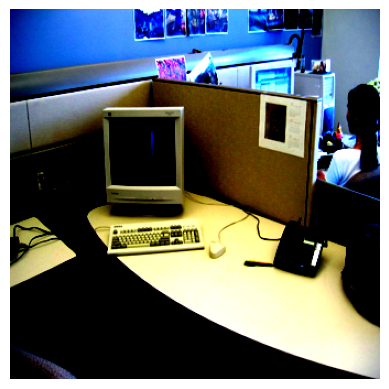

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
processed_example = small_processed_dataset[2]
processed_image = processed_example['image']
processed_image = np.transpose(processed_image, (1, 2, 0))

plt.imshow(processed_image)
plt.axis('off')
plt.show()


In [ ]:
from PIL import Image
import torch
from transformers import pipeline, MarianMTModel, MarianTokenizer
from IPython.display import display
from transformers import BitsAndBytesConfig

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
model_name = "llava-hf/llava-1.5-7b-hf"
pipe = pipeline("image-to-text", model=model_name, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

---------------Fine tuning model-------------

In [ ]:
# from sklearn.model_selection import train_test_split

# # Split your preprocessed dataset into training and testing sets
# train_data, test_data = train_test_split(small_processed_dataset, test_size=0.2, random_state=42)


----------zero shot  and testing on third image of the  small preprocessed data-----------

In [ ]:
#Translation Functions
def translate_ar_to_en(text, model_name="Helsinki-NLP/opus-mt-ar-en"):
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    translated = model.generate(**tokenizer.prepare_seq2seq_batch([text], return_tensors="pt"))
    return tokenizer.decode(translated[0], skip_special_tokens=True)

def translate_en_to_ar(text, model_name="Helsinki-NLP/opus-mt-en-ar"):
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    translated = model.generate(**tokenizer.prepare_seq2seq_batch([text], return_tensors="pt"))
    return tokenizer.decode(translated[0], skip_special_tokens=True)

In [ ]:
# Your question in Arabic
arabic_question = "ما هو لون الشعر الذي تمتلكه المرأة؟"

# Translate the question to English
english_question = translate_ar_to_en(arabic_question)

In [ ]:
prompt = f"USER: <image>\n{english_question}\nASSISTANT:"


In [ ]:
import numpy as np
from PIL import Image
import io

# Initialize 'image' with the third image in your preprocessed data
image_np = small_processed_dataset[0]['image'][2]  # Access the third image in the list

# Ensure the image has the correct shape (336, 336, 3) and data type
expected_shape = (336, 336, 3)
if np.array(image_np).shape != expected_shape:
    # If the shape is not as expected, resize the image to the expected shape
    image_np = np.array(image_np)
    image_pil = Image.fromarray((image_np * 255).astype('uint8'))
    image_pil = image_pil.resize((expected_shape[1], expected_shape[0]))

# Convert the resized NumPy array to a PIL image
image_pil = Image.fromarray((np.array(image_np) * 255).astype('uint8'))

# Now you can use 'image_pil' directly with the model pipeline
outputs = pipe(image_pil, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

# Translate the response back to Arabic
arabic_answer = translate_en_to_ar(outputs[0]["generated_text"])

print(arabic_answer)


ما لون شعر المرأة؟ شعر المرأة أسود


In [ ]:
# outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

# # Translate the response back to Arabic
# arabic_answer = translate_en_to_ar(outputs[0]["generated_text"])

# print(arabic_answer)

In [ ]:
# print(arabic_answer)